# varTFBridge — Common Variant Analysis Plots (K562)

Reproduces Figure 4 plots from the varTFBridge manuscript using pipeline output files.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, ListedColormap
from scipy.cluster.hierarchy import fcluster
from tqdm import tqdm
import gseapy as gp

# PDF-friendly fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Paths
PROJECT_ROOT = '.'
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
FIG_DIR = os.path.join(RESULTS_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

# Color palettes
TF_CHANGE_PALETTE = {
    'Disrupt': '#1f458d', 'Decrease': '#6e9dc3',
    'Create': '#2d6533', 'Increase': '#82b376'
}
TF_CHANGE_ORDER = ['Create', 'Increase', 'Disrupt', 'Decrease']
MANHATTAN_COLORS = ['#234895', '#71a4cc']

## 1. Load Data

### 1.1 Per-trait common variants at K562 footprints

In [2]:
# Load all erythroid trait fine-mapping variants overlapping K562 FOODIE footprints
allvars_dir = os.path.join(DATA_DIR, 'GWFM_erythroids', 'allvars_hg38_K562_foodie')
all_comvar_K562 = []
for fn in sorted(glob.glob(os.path.join(allvars_dir, '*_finemapping_allvars_hg38_K562_foodie.tsv'))):
    df = pd.read_csv(fn, sep='\t')
    df['trait'] = os.path.basename(fn).split('_')[0]
    all_comvar_K562.append(df)
all_comvar_K562 = pd.concat(all_comvar_K562).reset_index(drop=True)
all_comvar_K562['GENPOS'] = all_comvar_K562['End'].astype(int)
all_comvar_K562['CHROM'] = all_comvar_K562['Chromosome'].str.replace('chr', '').astype(int)
all_comvar_K562 = all_comvar_K562.rename(columns={'Position': 'Position_hg19'})

# Keep top PIP per variant (across traits)
all_comvar_K562_keepTopPIP = (
    all_comvar_K562[['Name', 'trait', 'PIP', 'A1Effect']]
    .sort_values(by=['Name', 'PIP'], ascending=[True, False])
    .drop_duplicates(subset=['Name'], keep='first')
    .reset_index(drop=True)
)

print(f'Traits loaded: {sorted(all_comvar_K562["trait"].unique())}')
print(f'Total variant-trait rows: {len(all_comvar_K562):,}')
print(f'Unique variants: {all_comvar_K562["Name"].nunique():,}')

Traits loaded: ['HC', 'HLDRC', 'HLSRP', 'HP', 'IRF', 'MCH', 'MCHC', 'MCV', 'MSCV', 'RBC', 'RBCDW', 'RC', 'RP']
Total variant-trait rows: 208,819
Unique variants: 16,063


### 1.2 Credible set information

In [3]:
# Load credible set variant info from footprint overlap results
cs_dir = os.path.join(RESULTS_DIR, 'comvar_footprint_overlap_credible', 'K562.merged.hg38')
cs_frames = []
for fn in sorted(glob.glob(os.path.join(cs_dir, '*_K562.merged.hg38.csv'))):
    df = pd.read_csv(fn)
    trait = os.path.basename(fn).split('_')[0]
    df['trait'] = trait
    cs_frames.append(df)
snp_cs = pd.concat(cs_frames).reset_index(drop=True)
snp_cs = snp_cs.rename(columns={'SNP': 'rsID'})

# Deduplicated: keep highest PEP_cs per rsID
snp_cs_dedup = (
    snp_cs.sort_values(by=['rsID', 'PEP_cs'], ascending=[True, False])
    .drop_duplicates(subset=['rsID'])
    .reset_index(drop=True)
)

print(f'Credible set variants (all traits): {snp_cs["rsID"].nunique():,}')
print(f'With PEP_cs >= 0.7: {snp_cs_dedup[snp_cs_dedup["PEP_cs"] >= 0.7].shape[0]:,}')

Credible set variants (all traits): 1,087
With PEP_cs >= 0.7: 268


## 2. Variant Overview Plots

### Plot 1: Traits per Variant (bar chart)

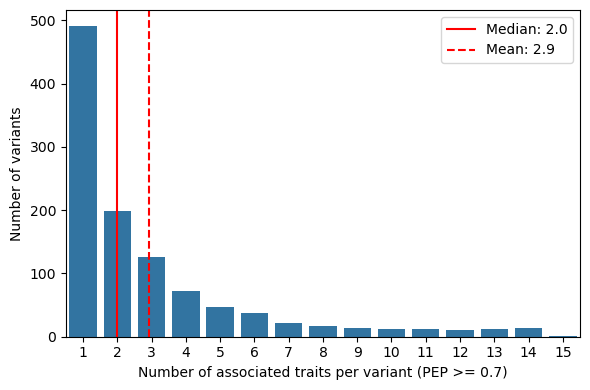

In [4]:
# Variants at K562 footprints that are also in credible sets
var_at_K562_foodie = list(
    set(all_comvar_K562['Name'].unique()) & set(snp_cs['rsID'].unique())
)
snp_cs_at_K562_fp = snp_cs.set_index('rsID').loc[var_at_K562_foodie].reset_index()

ntraits_per_vars = (
    snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique()
    .reset_index()
    .groupby('trait').count()
    .reset_index()
)
median_val = snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique().median()
mean_val = snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique().mean()

plt.figure(figsize=(6, 4))
sns.barplot(data=ntraits_per_vars, x='trait', y='rsID')
plt.axvline(x=median_val - 1, color='r', linestyle='-', label=f'Median: {median_val:.1f}')
plt.axvline(x=mean_val - 1, color='r', linestyle='--', label=f'Mean: {mean_val:.1f}')
plt.xlabel('Number of associated traits per variant (PEP >= 0.7)')
plt.ylabel('Number of variants')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_pep70_per_num_traits.pdf'), transparent=True, dpi=500)
plt.show()

### Plot 2: PIP Distribution (histogram)

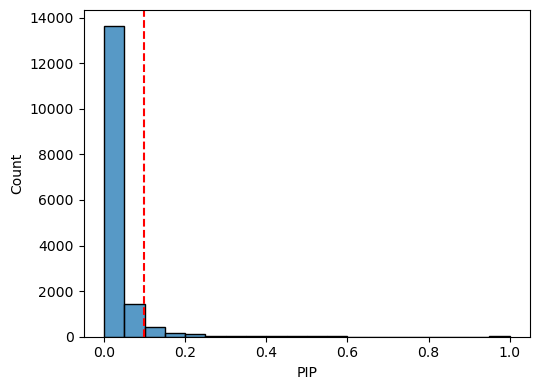

In [5]:
plt.figure(figsize=(5.5, 4))
sns.histplot(all_comvar_K562_keepTopPIP['PIP'], bins=20)
plt.axvline(x=0.1, color='r', linestyle='--')
plt.tight_layout()
# plt.savefig(os.path.join(FIG_DIR, 'figure4_K562_PIP_hist.pdf'), transparent=True)
plt.show()

### Plot 3: PEP Threshold (donut chart)

In [ ]:
# Merge top-PIP variants with credible set PEP_cs
merged_pep = all_comvar_K562_keepTopPIP.merge(
    snp_cs_dedup[['rsID', 'PEP_cs']].drop_duplicates(),
    left_on='Name', right_on='rsID', how='left'
)
n_pep_high = merged_pep[merged_pep['PEP_cs'] >= 0.7].shape[0]
n_pep_low = len(merged_pep) - n_pep_high

labels = ['PEP<0.7', 'PEP>=0.7']
data = [n_pep_low, n_pep_high]
colors = sns.color_palette('pastel')

def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{pct:.0f}%\n({absolute})"

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    data, colors=colors, startangle=0,
    autopct=lambda pct: autopct_format(pct, data),
    wedgeprops=dict(width=0.5)
)
ax.legend(wedges, labels, title='', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig(os.path.join(FIG_DIR, 'figure4_common_pip_piechart.pdf'), bbox_inches='tight', transparent=True)
plt.show()
print(f'PEP<0.7: {n_pep_low}, PEP>=0.7: {n_pep_high}')

### Plot 4: PIP Manhattan Plot

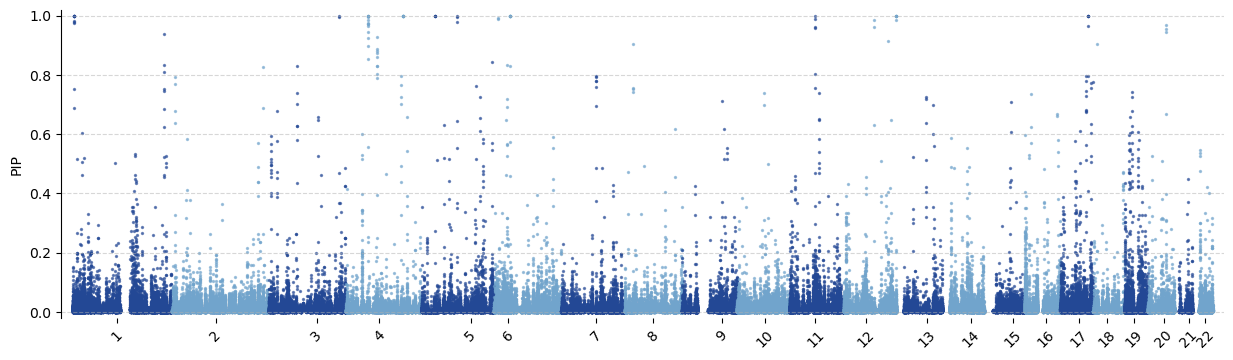

In [6]:
def plot_manhattan(ax, df, title='', threshold=5e-8, ymax=None, sign='LOG10P',
                   colors=('skyblue', 'navy')):
    df_plot = df.copy()
    df_plot['BP_cum'] = 0
    chrom_order = sorted(df_plot['CHROM'].unique(), key=lambda x: int(x))
    cum_bp = 0
    ticks, labels = [], []
    for chrom in chrom_order:
        mask = df_plot['CHROM'] == chrom
        df_plot.loc[mask, 'BP_cum'] = df_plot.loc[mask, 'GENPOS'] + cum_bp
        ticks.append(df_plot.loc[mask, 'BP_cum'].median())
        labels.append(chrom)
        cum_bp += df_plot.loc[mask, 'GENPOS'].max()
    for i, chrom in enumerate(chrom_order):
        chrom_data = df_plot[df_plot['CHROM'] == chrom]
        ax.scatter(chrom_data['BP_cum'], chrom_data[sign],
                   color=colors[i % len(colors)], s=2, alpha=0.6)
    ax.set_ylabel(sign)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    if threshold is not None:
        ax.axhline(threshold, color='red', linestyle='dashed', lw=1)
    ax.margins(x=0.01, y=0.02)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig, ax1 = plt.subplots(nrows=1, figsize=(15, 4))
plot_manhattan(ax1, all_comvar_K562, sign='PIP', threshold=None, colors=MANHATTAN_COLORS)
# plt.savefig(os.path.join(FIG_DIR, 'erythroid_common_manhattan.png'),
#             dpi=1000, transparent=True, bbox_inches='tight')
plt.show()

## 3. TF Binding Effects

### Load VAR2TFBS results

In [7]:
# Load VAR2TFBS results
var2tfbs = pd.read_csv(os.path.join(RESULTS_DIR, 'comvar_var2tfbs_results', 'K562_var2tfbs.csv'))

# Load TF expression
tf_expr = pd.read_csv(os.path.join(DATA_DIR, 'gene_expr', 'TF_K562_GM12878_expression.csv'))
var2tfbs = var2tfbs.merge(
    tf_expr[['TF', 'K562_rna_tpm']].rename(columns={'K562_rna_tpm': 'TF_K562_rna_tpm'}),
    on='TF', how='left'
)

# Merge with PIP and PEP_cs
var_tfbs_alt_ref_pip = var2tfbs.merge(
    all_comvar_K562_keepTopPIP.rename(columns={'Name': 'rsID'}), on='rsID'
)
var_tfbs_alt_ref_pip_cs = var_tfbs_alt_ref_pip.merge(
    snp_cs_dedup[['rsID', 'PEP_cs', 'CS_id']].drop_duplicates(), on='rsID', how='left'
).reset_index(drop=True)

# Filter: PIP >= 0.1, in credible set
var_tfbs_alt_ref_filtered = var_tfbs_alt_ref_pip_cs[
    (var_tfbs_alt_ref_pip_cs['PIP'] >= 0.1) & (~var_tfbs_alt_ref_pip_cs['PEP_cs'].isna())
].reset_index(drop=True)

# TF change event counts for bar chart
var_tfbs_change_event_count = (
    var_tfbs_alt_ref_filtered.groupby('TF_change').size()
    .reset_index(name='count')
)

# Affected variants (exclude Unchange)
var_tfbs_alt_ref_effected = var_tfbs_alt_ref_filtered[
    var_tfbs_alt_ref_filtered['TF_change'] != 'Unchange'
].reset_index(drop=True)

# TF-level counts for box/strip plot
TF_change_event_count = (
    var_tfbs_alt_ref_effected.groupby(['TF', 'TF_change']).size()
    .reset_index().rename(columns={0: 'count'})
)

print(f'VAR2TFBS total rsIDs: {var2tfbs["rsID"].nunique()}')
print(f'Filtered (PIP>=0.1, in CS): {var_tfbs_alt_ref_filtered["rsID"].nunique()} rsIDs')
print(f'With TF effect (excl Unchange): {var_tfbs_alt_ref_effected["rsID"].nunique()} rsIDs')

VAR2TFBS total rsIDs: 960
Filtered (PIP>=0.1, in CS): 220 rsIDs
With TF effect (excl Unchange): 217 rsIDs


### Plot 5: TFs Affected per Variant (box + strip plot)

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/1027841365.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


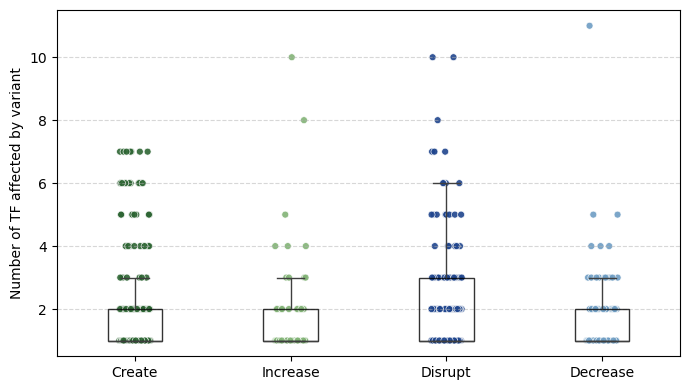

In [9]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=TF_change_event_count, x='TF_change', y='count',
    showfliers=False, width=0.35,
    boxprops={'facecolor': 'none', 'edgecolor': 'black', 'alpha': 0.8},
    order=TF_CHANGE_ORDER, zorder=3
)
sns.stripplot(
    data=TF_change_event_count, x='TF_change', y='count',
    palette=TF_CHANGE_PALETTE, alpha=0.9, s=5, jitter=True, zorder=0,
    linewidth=0.5, edgecolor='white', order=TF_CHANGE_ORDER
)
plt.xlim(-0.5, 3.5)
plt.grid(axis='y', ls='--', alpha=0.5)
plt.xlabel('')
plt.ylabel('Number of TF affected by variant')
plt.tight_layout()
# plt.savefig(os.path.join(FIG_DIR, 'figure4_TF_affected_by_var_stripplot.pdf'), transparent=True)
plt.show()

### Plot 6: TFBS Effect Count (horizontal bar chart)

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/267044160.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


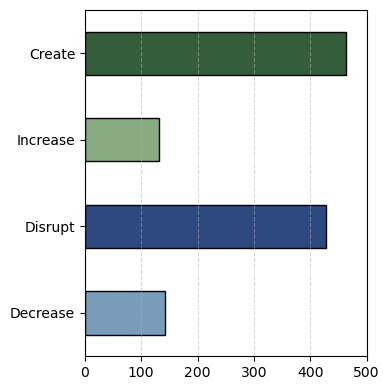

In [10]:
plt.figure(figsize=(4, 4))
ax = sns.barplot(
    data=var_tfbs_change_event_count,
    x='count', y='TF_change',
    palette=TF_CHANGE_PALETTE, width=0.5, linewidth=0.5,
    order=TF_CHANGE_ORDER
)
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.xlim(0, 500)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_TFBS_effect_count_PIP50.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

## 4. Variant-to-Gene Linking

### Load variant-to-gene data (ABC-FP-Max)

In [11]:
# Load ABC-FP-Max gene assignments
var2gene = pd.read_csv(os.path.join(RESULTS_DIR, 'var2gene_results', 'K562_comvar_ABC-FP-Max.csv'))

# Merge with TFBS-affected variants to get PIP and PEP_cs
affected_rsids = var_tfbs_alt_ref_effected[['rsID', 'foodie_id']].drop_duplicates()
K562_fp_atac_gene_var = var2gene.merge(affected_rsids, on=['rsID', 'foodie_id']).reset_index(drop=True)

# Add PIP and PEP_cs
K562_fp_atac_gene_var = K562_fp_atac_gene_var.merge(
    all_comvar_K562_keepTopPIP[['Name', 'PIP']].rename(columns={'Name': 'rsID'}),
    on='rsID', how='left'
)
K562_fp_atac_gene_var = K562_fp_atac_gene_var.merge(
    snp_cs_dedup[['rsID', 'PEP_cs']].drop_duplicates(), on='rsID', how='left'
)

# Deduplicate: keep best ABC score per variant
K562_fp_atac_gene_var_dedup = (
    K562_fp_atac_gene_var
    .sort_values(by=['rsID', 'ABC.Score'], ascending=[True, False])
    .drop_duplicates(subset=['rsID'], keep='first')
    .reset_index(drop=True)
)

# Filter: ABC > 0.015, PIP > 0.1, in credible set
K562_fp_atac_gene_var_filtered = K562_fp_atac_gene_var_dedup[
    (K562_fp_atac_gene_var_dedup['ABC.Score'] > 0.015) &
    (K562_fp_atac_gene_var_dedup['PIP'] > 0.1) &
    (~K562_fp_atac_gene_var_dedup['PEP_cs'].isna())
].reset_index(drop=True)

print(f'Variant-gene pairs (filtered): {len(K562_fp_atac_gene_var_filtered)}')
print(f'Unique genes: {K562_fp_atac_gene_var_filtered["TargetGene"].nunique()}')

Variant-gene pairs (filtered): 202
Unique genes: 190


### Plot 7: Variant-Gene Distance (histogram)

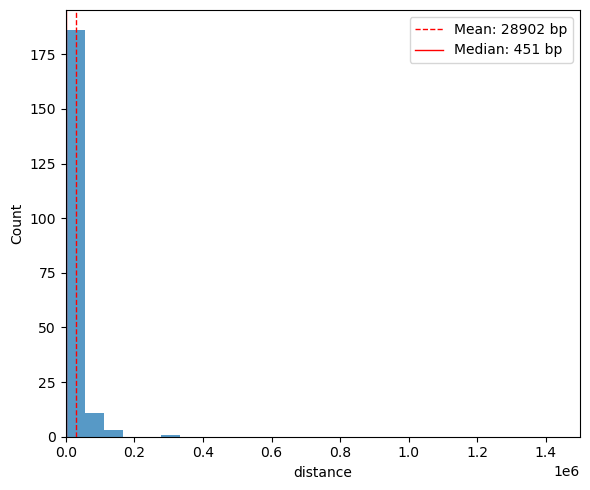

In [12]:
mean_dist = np.mean(K562_fp_atac_gene_var_filtered['distance'])
median_dist = np.median(K562_fp_atac_gene_var_filtered['distance'])

plt.figure(figsize=(6, 5))
sns.histplot(K562_fp_atac_gene_var_filtered['distance'], lw=0, bins=60)
plt.axvline(x=mean_dist, color='r', lw=1, linestyle='--',
            label=f'Mean: {mean_dist:.0f} bp')
plt.axvline(x=median_dist, color='r', lw=1, linestyle='-',
            label=f'Median: {median_dist:.0f} bp')
plt.xlim([-1, 1_500_000])
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_K562_fp_atac_gene_var_distance.pdf'),
            transparent=True, dpi=500)
plt.show()

### Plot 8: CRE Type (donut chart)

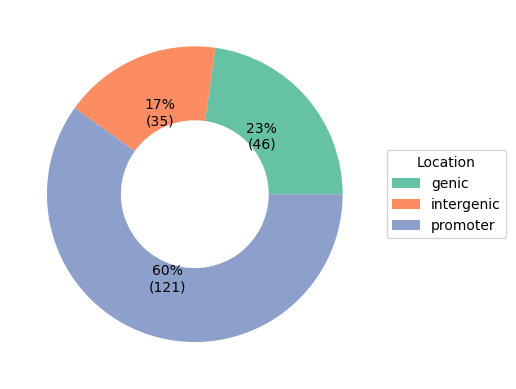

In [13]:
cre_counts = K562_fp_atac_gene_var_filtered.groupby('class').size().reset_index(name='count')
labels = cre_counts['class'].tolist()
data = cre_counts['count'].tolist()
colors = sns.color_palette('Set2')

def autopct_format_cre(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f"{pct:.0f}%\n({absolute})"

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    data, colors=colors, startangle=0,
    autopct=lambda pct: autopct_format_cre(pct, data),
    wedgeprops=dict(width=0.5)
)
ax.legend(wedges, labels, title='Location', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig(os.path.join(FIG_DIR, 'figure4_common_pep70_tfbs_cre_type.pdf'),
            bbox_inches='tight', transparent=True)
plt.show()

### Plot 9: GO Enrichment (scatter plot)

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/784782196.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


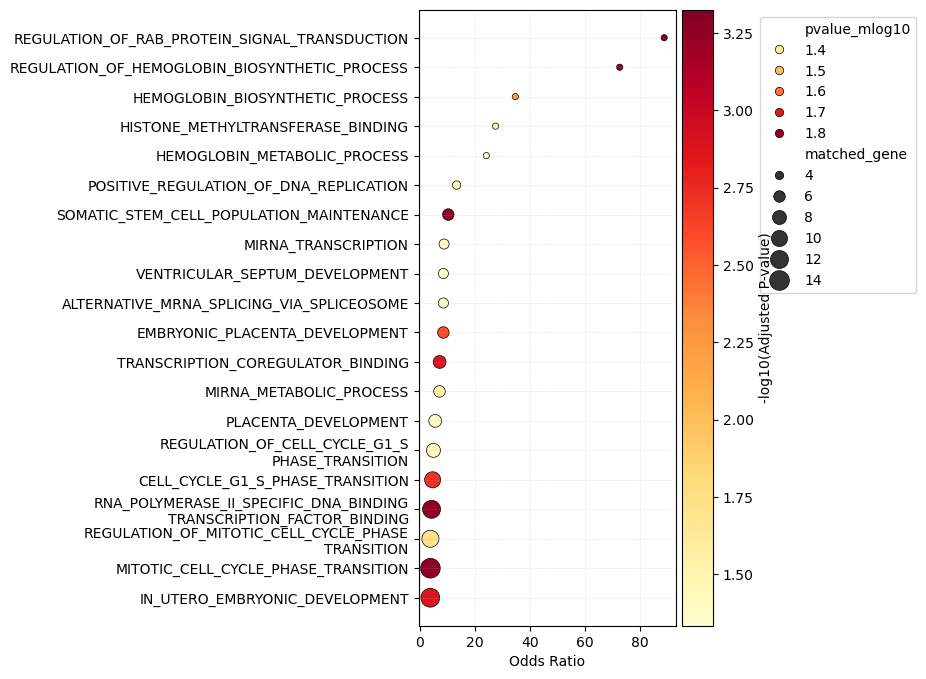

In [18]:
gene_list = list(K562_fp_atac_gene_var_filtered['TargetGene'].unique())
gmt_path = os.path.join(DATA_DIR, 'GSEA_MSigDB', 'c5.go.v2025.1.Hs.symbols.gmt')

enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=gmt_path,
    organism='Human',
    cutoff=0.05,
)
res2d_grp = enr.res2d
go_grp_sig = (
    res2d_grp[res2d_grp['Adjusted P-value'] < 0.05]
    .sort_values(by='Odds Ratio', ascending=False)
    .reset_index(drop=True)
)

# Process term names for display
go_grp_sig['Term_split'] = go_grp_sig['Term'].str.split('_').apply(
    lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:]) if len(x) > 7 else '_'.join(x[1:])
)
go_grp_sig['matched_gene'] = go_grp_sig['Overlap'].str.split('/').str[0].astype(int)
go_grp_sig['total_gene'] = go_grp_sig['Overlap'].str.split('/').str[1].astype(int)
go_grp_sig['pvalue_mlog10'] = -np.log10(go_grp_sig['Adjusted P-value'].astype(float))

plt.figure(figsize=(4, 8))
scatter = sns.scatterplot(
    data=go_grp_sig.head(20),
    y='Term_split', x='Odds Ratio',
    size='matched_gene', hue='pvalue_mlog10',
    palette='YlOrRd', sizes=(20, 200),
    edgecolor='black', linewidth=0.5
)

# Add colorbar
sm = plt.cm.ScalarMappable(
    cmap='YlOrRd',
    norm=Normalize(vmin=go_grp_sig['pvalue_mlog10'].min(),
                   vmax=go_grp_sig['pvalue_mlog10'].max())
)
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)')
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_go_enrichment_erythroid.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()

## 5. GRN Integration

### Build per-variant GRN summary

In [19]:
# Merge TFBS-affected variants with gene assignments
var_tfbs_alt_ref_effected_grn = var_tfbs_alt_ref_effected[
    ['TF', 'rsID', 'TF_change', 'TF_K562_rna_tpm']
].merge(K562_fp_atac_gene_var_filtered, on='rsID', how='outer')

# Filter to variants with gene assignment and TF expression > 0.5
var_tfbs_alt_ref_effected_grn_filtered = var_tfbs_alt_ref_effected_grn[
    (~var_tfbs_alt_ref_effected_grn['TargetGene'].isna()) &
    (var_tfbs_alt_ref_effected_grn['TF_K562_rna_tpm'] > 0.5)
].reset_index(drop=True)

# Build var_info_all: per-variant summary with Gene-TF label
sel_cols = ['rsID', 'class', 'TargetGene', 'distance', 'isSelfPromoter',
            'hic_contact', 'activity_base', 'ABC.Score', 'ABC.Score.FP',
            'foodie_id', 'PIP']
var_info_all = []
for rs_id in tqdm(var_tfbs_alt_ref_effected_grn_filtered['rsID'].unique()):
    var_data = var_tfbs_alt_ref_effected_grn_filtered[
        var_tfbs_alt_ref_effected_grn_filtered['rsID'] == rs_id
    ]
    available_cols = [c for c in sel_cols if c in var_data.columns]
    var_info = var_data[available_cols].drop_duplicates().reset_index(drop=True)
    tf_change_stats = dict(var_data.groupby('TF_change')['TF'].unique())
    change_str = '|'.join(
        f"{tfc}:{','.join(tf_change_stats[tfc])}" for tfc in tf_change_stats
    )
    var_info['TF_changes'] = change_str
    var_info_all.append(var_info)

var_info_all = (
    pd.concat(var_info_all)
    .sort_values(by='PIP', ascending=False)
    .reset_index(drop=True)
)
var_info_all['Gene-TF'] = var_info_all['TargetGene'] + '-' + var_info_all['TF_changes']

print(f'GRN variants: {var_info_all["rsID"].nunique()}')

100%|██████████| 183/183 [00:00<00:00, 1366.97it/s]

GRN variants: 183


In [20]:
# Build per-variant per-trait effect table
TF_list = var_tfbs_alt_ref_effected['TF'].unique().tolist()
change_idx_dict = {'Disrupt': -2, 'Decrease': -1, 'Increase': 1, 'Create': 2}
var_tfbs_alt_ref_effected_index = var_tfbs_alt_ref_effected.set_index(['rsID', 'TF'])
trait_list = all_comvar_K562['trait'].unique().tolist()

# Add per-trait PIP and per-TF change scores to var_info_all
for idx, row in var_info_all.iterrows():
    rsid = row['rsID']
    rsid_fm = all_comvar_K562[all_comvar_K562['Name'] == rsid]
    for _, fm_row in rsid_fm.iterrows():
        var_info_all.at[idx, fm_row['trait']] = fm_row['PIP']
    for tf in TF_list:
        try:
            tf_res = var_tfbs_alt_ref_effected_index.loc[(rsid, tf)]
            var_info_all.at[idx, tf] = change_idx_dict[tf_res.loc['TF_change']]
        except Exception:
            var_info_all.at[idx, tf] = 0

# Build var_info_df: expanded per-trait rows
all_comvar_K562_index = all_comvar_K562.set_index(['Name', 'trait'])
var_info = []
for idx, row in var_info_all.iterrows():
    for trait in trait_list:
        try:
            effect = all_comvar_K562_index.loc[(row['rsID'], trait), 'A1Effect']
            freq = all_comvar_K562_index.loc[(row['rsID'], trait), 'A1Frq']
            pip = all_comvar_K562_index.loc[(row['rsID'], trait), 'PIP']
            var_info.append([
                row['rsID'], row['TF_changes'], row['TargetGene'],
                pip, row.get('ABC.Score', np.nan), row.get('hic_contact', np.nan),
                row.get('activity_base', np.nan), effect, freq, trait
            ])
        except Exception:
            pass

var_info_df = pd.DataFrame(var_info, columns=[
    'rsID', 'TF', 'TargetGene', 'PIP', 'ABC.Score', 'hic_contact',
    'activity_base', 'effect', 'freq', 'trait'
])
var_info_df['Gene-TF'] = var_info_df['TargetGene'] + '-' + var_info_df['TF']

print(f'var_info_df rows: {len(var_info_df)}')

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/3334690630.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_info_all.at[idx, tf] = 0
/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/3334690630.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_info_all.at[idx, tf] = 0
/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/3334690630.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

var_info_df rows: 2379


### Plot 10: rs112233623 Effect Size Across Traits

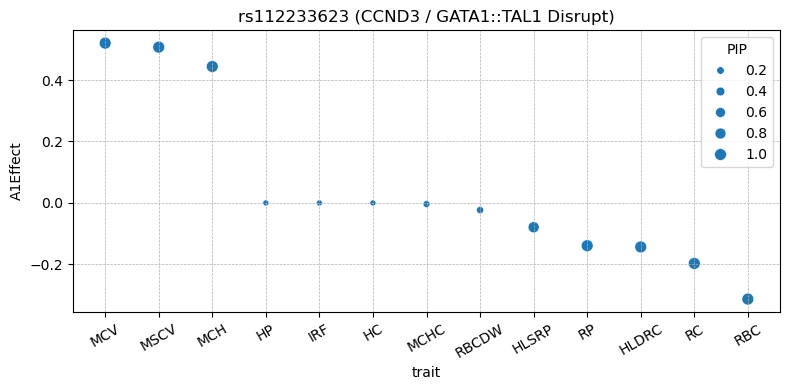

In [21]:
ccnd3var = (
    all_comvar_K562[all_comvar_K562['Name'] == 'rs112233623']
    .reset_index(drop=True)
    .sort_values(by='A1Effect', ascending=False)
)
plt.figure(figsize=(8, 4))
sns.scatterplot(data=ccnd3var, x='trait', y='A1Effect', size='PIP')
plt.xticks(rotation=30)
plt.grid(linewidth=0.5, linestyle='--')
plt.title('rs112233623 (CCND3 / GATA1::TAL1 Disrupt)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_rs112233623_effect.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

### Plot 11: Gene-TF-Trait Clustermap (top 30)

/Users/jieconglin/miniconda3/envs/foodie_env/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


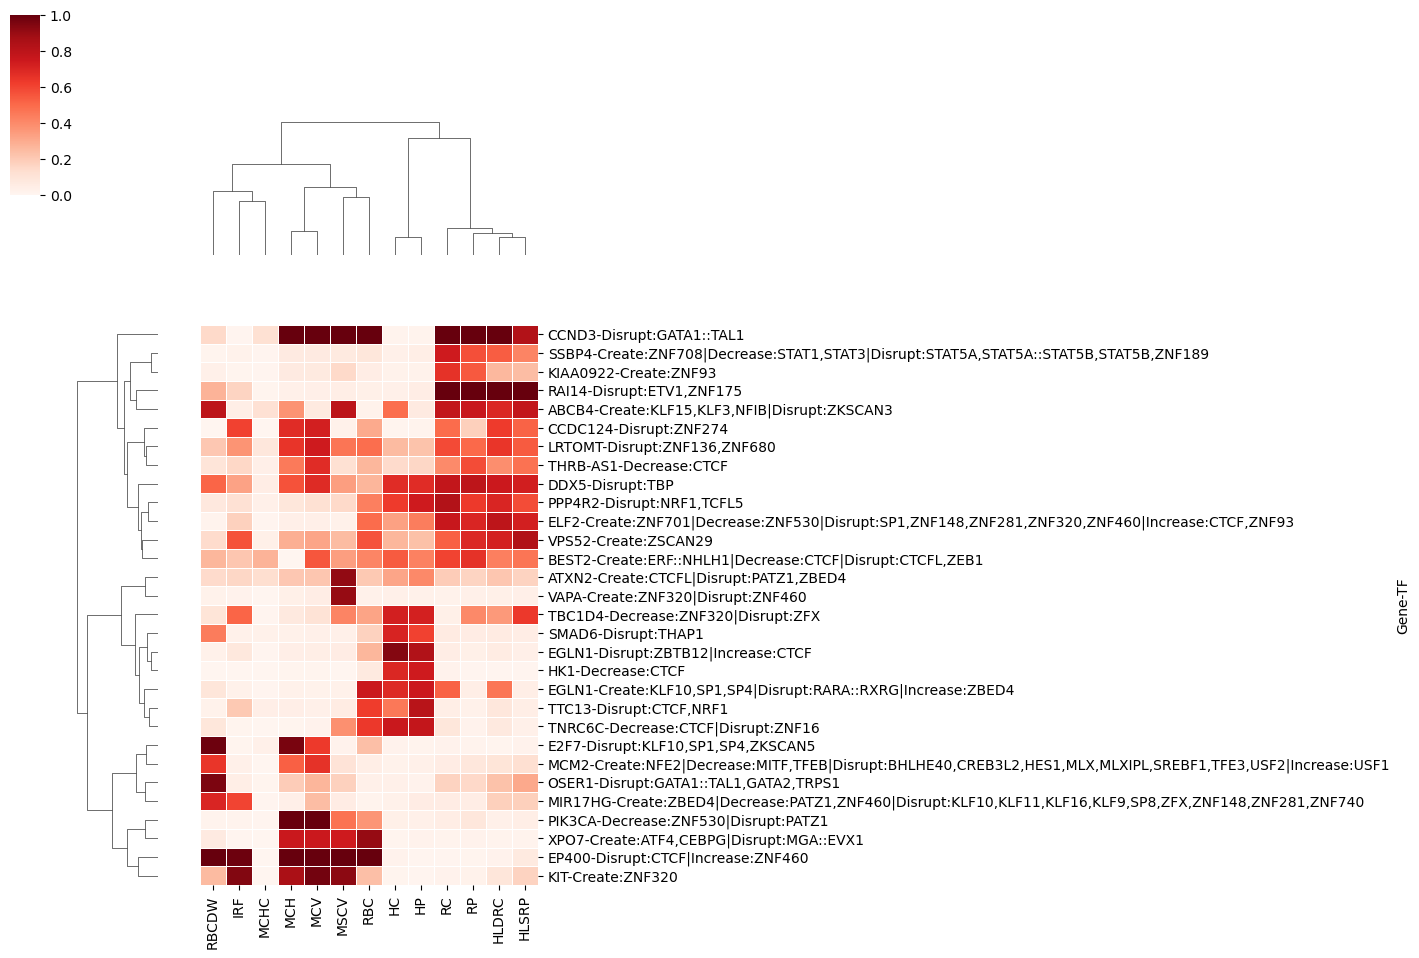

In [22]:
var_info_top30 = var_info_all.head(30)
gene_tf_trait = var_info_top30.set_index('Gene-TF')[trait_list].fillna(0).astype(float)

cg = sns.clustermap(
    gene_tf_trait,
    method='ward', metric='euclidean',
    linewidths=0.5, cmap='Reds', figsize=(6, 10)
)
plt.savefig(os.path.join(FIG_DIR, 'figure4_gene_tf_trait_clustermap.pdf'),
            transparent=True, bbox_inches='tight')
plt.show()

# Save reordered indices for composite figure
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
df_reordered = gene_tf_trait.iloc[row_order, col_order]

## 6. AlphaGenome Integration

### Load AlphaGenome scores

In [23]:
# Load AlphaGenome scores
alphascore_df = pd.read_csv(
    os.path.join(DATA_DIR, 'alphagenome_results', 'K562_credible_comvar_pip70.tsv'),
    sep='\t'
)

# Filter to K562 H3K27ac
alphascore_H3k27ac = alphascore_df[
    (alphascore_df['biosample_name'] == 'K562') &
    (alphascore_df['histone_mark'] == 'H3K27ac')
].reset_index(drop=True)

# Filter K562 TF scores
alphascore_tf = alphascore_df[
    (alphascore_df['biosample_name'] == 'K562')
].dropna(subset=['transcription_factor']).reset_index(drop=True)

# Build variant_id in all_comvar_K562 for merging
# AlphaGenome format: chrX:POS:REF>ALT
alpha_variant_ids = set(alphascore_df['variant_id'].unique())

# Try both A1>A2 and A2>A1 to find which matches AlphaGenome IDs
all_comvar_K562['variant_id_1'] = (
    all_comvar_K562['Chromosome'] + ':' +
    all_comvar_K562['GENPOS'].astype(str) + ':' +
    all_comvar_K562['A1'] + '>' + all_comvar_K562['A2']
)
all_comvar_K562['variant_id_2'] = (
    all_comvar_K562['Chromosome'] + ':' +
    all_comvar_K562['GENPOS'].astype(str) + ':' +
    all_comvar_K562['A2'] + '>' + all_comvar_K562['A1']
)

# Assign whichever matches
all_comvar_K562['variant_id'] = np.where(
    all_comvar_K562['variant_id_1'].isin(alpha_variant_ids),
    all_comvar_K562['variant_id_1'],
    np.where(
        all_comvar_K562['variant_id_2'].isin(alpha_variant_ids),
        all_comvar_K562['variant_id_2'],
        np.nan
    )
)

# Map rsID to AlphaGenome variant_id
rsid_variant_map = (
    all_comvar_K562[['Name', 'variant_id']]
    .rename(columns={'Name': 'rsID'})
    .dropna(subset=['variant_id'])
    .drop_duplicates()
)
alphascore_H3k27ac = alphascore_H3k27ac.merge(rsid_variant_map, on='variant_id')
alphascore_tf = alphascore_tf.merge(rsid_variant_map, on='variant_id')

print(f'AlphaGenome H3K27ac variants mapped: {alphascore_H3k27ac["rsID"].nunique()}')
print(f'AlphaGenome TF variants mapped: {alphascore_tf["rsID"].nunique()}')

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/3782695588.py:2: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  alphascore_df = pd.read_csv(


AlphaGenome H3K27ac variants mapped: 30
AlphaGenome TF variants mapped: 30


In [24]:
# Merge H3K27ac scores into var_info_df
var_info_df = var_info_df.merge(
    alphascore_H3k27ac[['rsID', 'histone_mark', 'raw_score', 'quantile_score']],
    on='rsID', how='left'
).reset_index(drop=True)

# Build alphascore_top30_dedup: AlphaGenome TF scores + TFBS change for top 30 variants
top30_rsids = var_info_all.head(30)['rsID'].unique()

# Get all TFBS entries (including Unchange) for top 30 variants
top30_all_tfbs = var_tfbs_alt_ref_filtered[
    var_tfbs_alt_ref_filtered['rsID'].isin(top30_rsids)
][['rsID', 'TF', 'TF_change']].drop_duplicates()

# Merge AlphaGenome TF scores with TFBS change
alphascore_top30 = alphascore_tf[alphascore_tf['rsID'].isin(top30_rsids)].copy()
alphascore_top30_dedup = alphascore_top30.merge(
    top30_all_tfbs.rename(columns={'TF': 'TF_fimo', 'TF_change': 'tfbs_change'}),
    on='rsID', how='left'
)
# If no TFBS match, label as Unchange (note: original notebook had typo 'Uncahnge')
alphascore_top30_dedup['tfbs_change'] = alphascore_top30_dedup['tfbs_change'].fillna('Uncahnge')

print(f'AlphaGenome top30 entries: {len(alphascore_top30_dedup)}')

AlphaGenome top30 entries: 33048


### Plot 12: Composite Figure — var2GRN (4-panel)

/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/741234364.py:83: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=unchanged_tfbs, y='rsID', x='raw_score',
/var/folders/4j/r1qm_vwn60n7wllcr491152w0000gp/T/ipykernel_70481/741234364.py:106: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


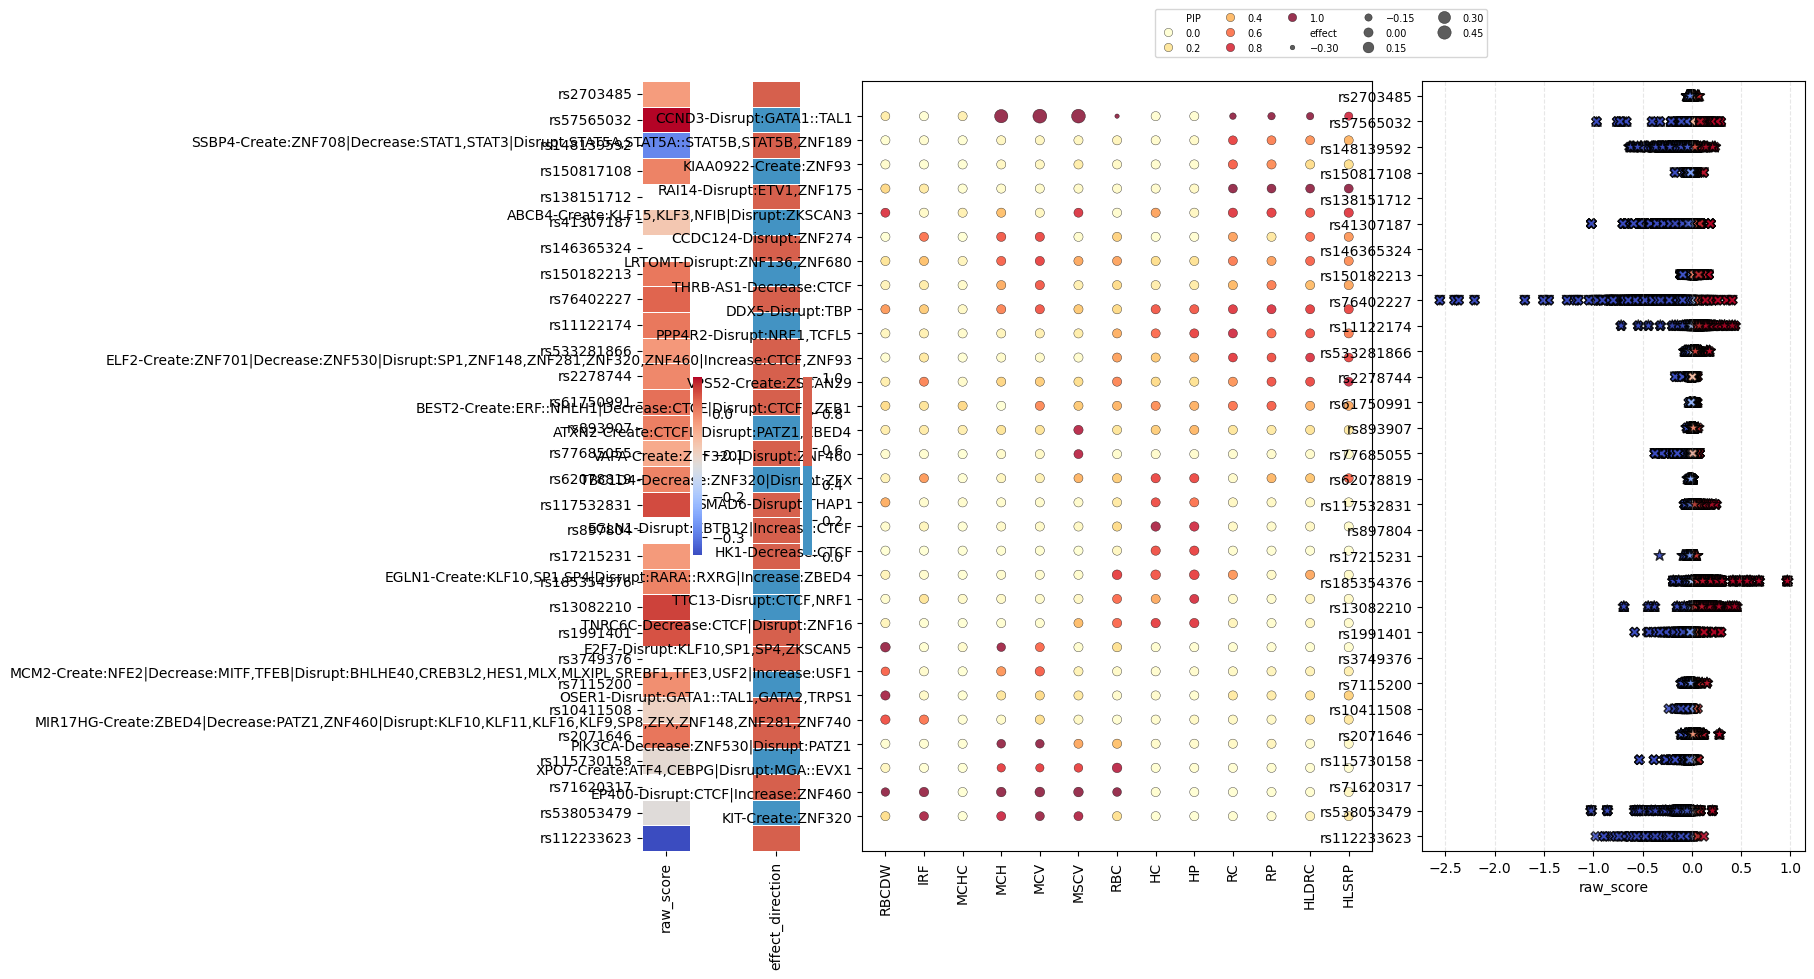

In [25]:
# Prepare data in clustered order
valid_gene_tfs = [idx for idx in df_reordered.index if idx in var_info_df['Gene-TF'].values]
var_info_df_ordered = var_info_df.set_index('Gene-TF').loc[valid_gene_tfs].reset_index()

desired_trait_order = df_reordered.columns
var_info_df_ordered['effect_direction'] = var_info_df_ordered['effect'] > 0
var_info_df_ordered['trait'] = pd.Categorical(
    var_info_df_ordered['trait'], categories=desired_trait_order, ordered=True
)

# Reorder alphascore_top30 to match
ordered_rsids = list(var_info_df_ordered['rsID'].drop_duplicates())
alphascore_top30_dedup_order = alphascore_top30_dedup[
    alphascore_top30_dedup['rsID'].isin(ordered_rsids)
].copy()
alphascore_top30_dedup_order['rsID'] = pd.Categorical(
    alphascore_top30_dedup_order['rsID'], categories=ordered_rsids[::-1], ordered=True
)
alphascore_top30_dedup_order = alphascore_top30_dedup_order.sort_values('rsID')

norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

# Split by TFBS change type
unchanged_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Uncahnge']
decreased_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Decrease']
increased_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Increase']
disrupted_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Disrupt']
create_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Create']

# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(15, 10),
                          gridspec_kw={'width_ratios': [0.7, 0.7, 6, 4.5]})

# Panel 1: AlphaGenome H3K27ac raw_score heatmap
heatmap_data_1 = (
    var_info_df_ordered.drop_duplicates(subset=['rsID'])
    .set_index('Gene-TF')
)
heatmap_idx = [idx for idx in df_reordered.index[::-1] if idx in heatmap_data_1.index]
heatmap_data_1 = heatmap_data_1.loc[heatmap_idx][['rsID', 'raw_score']].set_index('rsID')

sns.heatmap(
    data=heatmap_data_1, cmap='coolwarm', cbar=True,
    ax=axes[0], xticklabels=True, yticklabels=True, linewidths=0.5
)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)

# Panel 2: Effect direction heatmap
heatmap_data_2 = (
    var_info_df_ordered.drop_duplicates(subset=['rsID'])
    .set_index('Gene-TF')
)
heatmap_data_2 = heatmap_data_2.loc[heatmap_idx][['rsID', 'effect_direction']].set_index('rsID')
heatmap_data_2['effect_direction'] = heatmap_data_2['effect_direction'].astype(int)

sns.heatmap(
    data=heatmap_data_2, cmap=ListedColormap(['#4393c3', '#d6604d']),
    cbar=True, ax=axes[1], xticklabels=True, yticklabels=False, linewidths=0.5
)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelrotation=90)

# Panel 3: Gene-TF-trait scatter
sns.scatterplot(
    data=var_info_df_ordered, y='Gene-TF', x='trait',
    size='effect', hue='PIP', palette='YlOrRd',
    sizes=(10, 100), edgecolor='black', linewidth=0.3, alpha=0.8,
    ax=axes[2]
)
axes[2].tick_params(axis='x', labelrotation=90)
axes[2].set_ylabel('')
axes[2].set_xlabel('')
axes[2].legend(
    bbox_to_anchor=(0.9, 1.1), loc='upper center',
    ncol=5, frameon=True, fontsize=7
)

# Panel 4: AlphaGenome TFBS change scatter
sns.scatterplot(data=alphascore_top30_dedup_order, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                s=15, alpha=0.6, ax=axes[3], legend=False)
sns.scatterplot(data=unchanged_tfbs, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                marker='o', s=15, ax=axes[3], alpha=0.1, legend=False)
sns.scatterplot(data=decreased_tfbs, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                marker='v', s=45, ax=axes[3], alpha=0.8, linewidth=1,
                edgecolors='black', legend=False)
sns.scatterplot(data=increased_tfbs, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                marker='^', s=45, ax=axes[3], alpha=0.8, linewidth=1,
                edgecolors='black', legend=False)
sns.scatterplot(data=disrupted_tfbs, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                marker='X', s=45, ax=axes[3], alpha=0.8, linewidth=1,
                edgecolors='black', legend=False)
sns.scatterplot(data=create_tfbs, y='rsID', x='raw_score',
                hue='quantile_score', palette='coolwarm', hue_norm=norm,
                marker='*', s=70, ax=axes[3], alpha=0.8, linewidth=1,
                edgecolors='black', legend=False)
axes[3].margins(y=0.02)
axes[3].grid(axis='x', linestyle='--', alpha=0.3)
axes[3].set_ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure4_comvar2grn_v2.pdf'),
            transparent=True, format='pdf', bbox_inches='tight')
plt.show()

In [26]:
comvar_merge = pd.read_csv('results/K562_comvar2grn.csv')
comvar_merge 

,rsID,Chromosome,Start,End,A1,A2,freq,footprint_region,trait,PIP,...,TF_K562_rna_tpm,TargetGene,ABC.Score,ABC.Score.FP,distance,enhancer_class,alphag_H3K27ac_score,alphag_H3K27ac_quantile,alphag_ATAC_score,alphag_ATAC_quantile
0,rs17037388,chr1,11797978,11797979,G,A,0.164648,chr1:11797975-11797989,RBC,0.101370,...,0.544510,CLCN6,0.137172,0.135723,7851.5,genic,-0.148862,-0.994571,-0.166834,-0.979925
1,rs17037388,chr1,11797978,11797979,G,A,0.164648,chr1:11797975-11797989,RBC,0.101370,...,1.521600,CLCN6,0.137172,0.135723,7851.5,genic,-0.148862,-0.994571,-0.166834,-0.979925
2,rs17037388,chr1,11797978,11797979,G,A,0.164648,chr1:11797975-11797989,RBC,0.101370,...,3.650610,CLCN6,0.137172,0.135723,7851.5,genic,-0.148862,-0.994571,-0.166834,-0.979925
3,rs34484514,chr1,25246492,25246493,G,T,0.042455,chr1:25246487-25246517,MSCV,0.605670,...,0.706646,RSRP1,0.050981,0.064145,1150.0,genic,-0.014601,-0.879325,0.015831,0.421820
4,rs34484514,chr1,25246492,25246493,G,T,0.042455,chr1:25246487-25246517,RC,0.504918,...,0.706646,RSRP1,0.050981,0.064145,1150.0,genic,-0.014601,-0.879325,0.015831,0.421820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,rs131805,chr22,50525723,50525724,T,C,0.212150,chr22:50525710-50525731,LP,0.165716,...,0.034956,SCO2,1.000000,0.633947,746.0,promoter,-0.023757,-0.931910,-0.032862,-0.737944
3278,rs131805,chr22,50525723,50525724,T,C,0.212150,chr22:50525710-50525731,MSCV,0.316442,...,4.867306,SCO2,1.000000,0.633947,746.0,promoter,-0.023757,-0.931910,-0.032862,-0.737944
3279,rs131805,chr22,50525723,50525724,T,C,0.212150,chr22:50525710-50525731,MSCV,0.316442,...,0.034956,SCO2,1.000000,0.633947,746.0,promoter,-0.023757,-0.931910,-0.032862,-0.737944
3280,rs131805,chr22,50525723,50525724,T,C,0.212150,chr22:50525710-50525731,RP,0.222469,...,4.867306,SCO2,1.000000,0.633947,746.0,promoter,-0.023757,-0.931910,-0.032862,-0.737944
